## Sentiment Analysis Task
In this task, one will create a classification model that will be able to receive a sentence and give the sentiment of the sentence.

    * We will use this dataset: https://huggingface.co/datasets/sentiment140 for training and evaluation

    * We will use tweets from lesson 1 for inference
    
    * The model will be deployed. Follow the fine tuning process that we used during the class exercises when using LM

    * You will first use traditional ML then use Language models and compare the results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We have a class called Ml Model
path_other_datasets = "/content/drive/MyDrive/Colab Notebooks/nlp_training_ff_giz/projects/trainingandtestdata.zip"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebook/nlp_training_ff_giz/projects/trainingandtestdata.zip"

unzip:  cannot find or open /content/drive/MyDrive/Colab Notebook/nlp_training_ff_giz/projects/trainingandtestdata.zip, /content/drive/MyDrive/Colab Notebook/nlp_training_ff_giz/projects/trainingandtestdata.zip.zip or /content/drive/MyDrive/Colab Notebook/nlp_training_ff_giz/projects/trainingandtestdata.zip.ZIP.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import re
import gensim
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

#***I. TODO LOAD THE DATASET***

In [ ]:
train= pd.read_csv("/content/training.1600000.processed.noemoticon.csv",names=['polarity', 'id', 'date', 'query', 'user', 'text'],encoding='latin-1')
train.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
print('shape of train dataset',train.shape)
train.polarity.value_counts()

shape of train dataset (1600000, 6)


4    800000
0    800000
Name: polarity, dtype: int64

#***II. TODO PREPOCESS AND EXPLORE THE DATA***

In [ ]:
train1= train.drop(['id', 'date', 'query', 'user'], axis = 1)
#df = df.drop(columns=['id', 'date', 'query', 'user'])
train1.head()

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# 1=Positive tweet and 0=Negative tweet
train1.polarity = train1.polarity.replace({0: 0, 4: 1})
train1.polarity.value_counts()

1    800000
0    800000
Name: polarity, dtype: int64

In [ ]:
data_positive=train1[train1['polarity']>=1][:10000]
data_negative=train1[train1['polarity']<1][:10000]
data=pd.concat([data_positive,data_negative])

In [ ]:
data.polarity.value_counts()

1    10000
0    10000
Name: polarity, dtype: int64

In [ ]:
data.head()

,polarity,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


In [ ]:
# clean text to remove users, links and stopwords and then split it in tokens
def clean_text(text):
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    
    return " ".join(tokens)

In [ ]:
import nltk
nltk.download('stopwords')
# apply clean_text function in our data
data.text = data.text.apply(lambda x: clean_text(x))
# show the first five rows of data (to verify again)
data.sample(4)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,polarity,text
801405,1,many files
5975,0,im going lose followers one tweet lol
803503,1,today see soon
802448,1,wish could hopin get facetime gotta give scarf...


In [ ]:
df=data[['text','polarity']]
df.tail()

,text,polarity
9995,aww sad,0
9996,stupid dvds stuffing good bits jaws,0
9997,close friends family afraid work colleague,0
9998,crap looking last tweeted early 10 like 12,0
9999,another rainboot day,0


In [ ]:
print('Number of all texts:', len(df), '\n')
print('Number of positive texts:', len(df[df.polarity == 1]))
print('Number of negative texts:', len(df[df.polarity == 0]), '\n')

Number of all texts: 20000 

Number of positive texts: 10000
Number of negative texts: 10000 



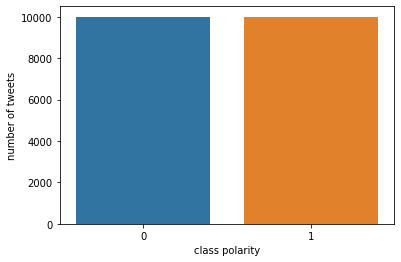

In [ ]:
sns.countplot(df.polarity,)
plt.xlabel('class polarity')
plt.ylabel('number of tweets')
plt.show()

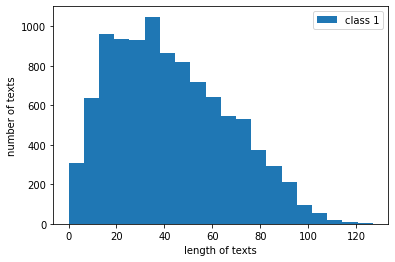

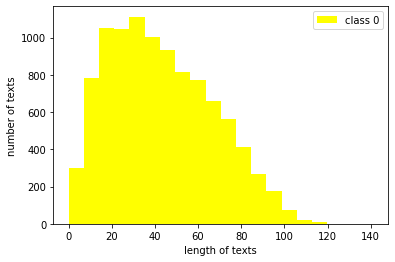

In [ ]:
plt.hist(df[df['polarity']==1].text.str.len(),bins=20,label='class 1')
plt.legend()
plt.xlabel('length of texts')
plt.ylabel('number of texts')
plt.show()
plt.hist(df[df['polarity']==0].text.str.len(),color='yellow',bins=20,label='class 0')
plt.legend()
plt.xlabel('length of texts')
plt.ylabel('number of texts')
plt.show()

#***Splitting our train dataset into X_train and y_train***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
df.head()

,text,polarity
800000,love health4uandpets u guys r best,1
800001,im meeting one besties tonight cant wait girl ...,1
800002,thanks twitter add sunisa got meet hin show dc...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,effect everyone,1


In [ ]:
val=df.iloc[7852]
val['text']

'okaayy newbie kinda like twitter yeah heard gotta go see u guys tom nyt h'

In [ ]:
# Splitting Train Test Data
X, y = df['text'].astype('str'), df['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Text vectorizing and Save the model into Joblib
import joblib
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)
joblib.dump(cv,'countvector.pkl')
X_test_vec= cv.transform(X_test)

In [ ]:
# class to be reused for traditional ML

from sklearn import svm
from sklearn import linear_model
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib
from sklearn.metrics import classification_report
import json

class MLModel:
  def __init__(self, target_model, save_path):
    self.save_path = save_path
    self.models = {"ols":linear_model.LinearRegression(), # regression
            "svm":svm.SVC(),
            "ridge":linear_model.Ridge(alpha=.5), # regression
            "lasso":linear_model.Lasso(alpha=0.1), # regression
            "knn":neighbors.KNeighborsClassifier(5), 
            "logistic":linear_model.LogisticRegression(),
            "nb":MultinomialNB(),
            "randomforest":RandomForestClassifier(n_estimators=10),
            "sgd_svm":linear_model.SGDClassifier(max_iter=1000, tol=1e-3)} # you can add more models as pleased
    
    if target_model is not None:
      if target_model in self.models.keys():
        self.model = self.models[target_model]
      else:
        raise NotImplementedError
    
    self.clf = None
  
  def fit(self, X, y, max_iter=None):
    #put your code down here
    self.clf = self.model.fit(X, y, max_iter=max_iter) if max_iter else self.model.fit(X, y)

  def save(self, mode="pickle"):
    if mode == "pickle":
      if self.clf is not None:
        joblib.dump(self.clf, self.save_path)
      else:
        raise ValueError("train before saving the classifier")

    elif mode == "json":
      if self.clf is not None:
        model_dict = {}
        model_dict["clf"] = self.clf
        json_clf = json.dumps(model_dict, indent=4)
        with open(self.save_path+"/model.json", 'w') as file:
            file.write(json_clf)
        file.close()
      else:
        raise ValueError("Train before saving the classifier")
    else:
      raise NotImplementedError

  def load(self, path, mode):
    if mode == "pickle":
      self.clf = joblib.load(path)
      print(self.clf)
    elif mode == "json":
      with open(path, 'r') as file:
          model_dict = json.load(file)
      self.clf = model_dict["clf"]
    else:
      raise NotImplementedError
    return self.clf

  def predict(self, X):
    predictions = self.clf.predict(X)
    return predictions

  def evaluate(self, y_true, y_pred, target_names):
    # put your code down here add eval
    print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
"""from sklearn import linear_model
clf=linear_model.LogisticRegression(max_iter=1000)
clf.fit(X_train_vec,y_train)
pred=clf.predict(X_test_vec)

print('accuracy:',sum(pred==y_test)*1.0/len(y_test))"""

"from sklearn import linear_model\nclf=linear_model.LogisticRegression(max_iter=1000)\nclf.fit(X_train_vec,y_train)\npred=clf.predict(X_test_vec)\n\nprint('accuracy:',sum(pred==y_test)*1.0/len(y_test))"

In [ ]:
# calling the ML calss For Logistic Regression
model_logistic = MLModel("logistic", "./logistic.pkl")
model_logistic.fit(X=X_train_vec, y=y_train)
Logistic_pred = model_logistic.predict(X_test_vec)
print("accuracy: ", sum(Logistic_pred==y_test)*1.0/len(y_test))

print("Full classification evaluation report:")
model_logistic.evaluate(Logistic_pred, y_test, target_names=[str(i) for i in np.unique(y_test)])

accuracy:  0.7222
Full classification evaluation report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2447
           1       0.73      0.72      0.73      2553

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [ ]:
Logistic_pred

array([0, 0, 1, ..., 0, 0, 0])

Text(15.0, 0.5, 'Actual')

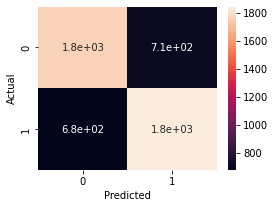

In [ ]:
cm = confusion_matrix(y_test,Logistic_pred)
cm
# after creating the confusion matrix, for better understaning plot the cm.
import seaborn as sn
plt.figure(figsize = (4,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# save model for reuse LOGISTIC REGRESSION
model_logistic.save()

In [ ]:
loaded_logistic_model = model_logistic.load('./logistic.pkl',  mode="pickle")
Logistic_predict = loaded_logistic_model.predict(X_test_vec)
print(Logistic_predict)
sum(Logistic_predict==y_test)*1.0/len(y_test)
model_logistic.evaluate(Logistic_predict, y_test, target_names=[str(i) for i in np.unique(y_test)])

LogisticRegression()
[0 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2447
           1       0.73      0.72      0.73      2553

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [ ]:
# calling the ML calss For MULTINOMIAL NAIVE BAYES
model_nb = MLModel("nb", "./nb.pkl")
model_nb.fit(X=X_train_vec, y=y_train)
NB_pred = model_nb.predict(X_test_vec)
print("accuracy: ", sum(NB_pred==y_test)*1.0/len(y_test))

print("Full classification evaluation report:")
model_nb.evaluate(NB_pred, y_test, target_names=[str(i) for i in np.unique(y_test)])

accuracy:  0.7156
Full classification evaluation report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      2678
           1       0.68      0.74      0.71      2322

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



Text(15.0, 0.5, 'Actual')

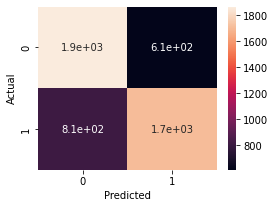

In [ ]:
cm = confusion_matrix(y_test,NB_pred)
cm
# after creating the confusion matrix, for better understaning plot the cm.
import seaborn as sn
plt.figure(figsize = (4,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# save model for reuse MULTINOMIAL NAIVE BAYES
model_nb.save()

In [ ]:
loaded_nb_model = model_nb.load('./nb.pkl',  mode="pickle")
NB_predict = loaded_nb_model.predict(X_test_vec)
print(NB_predict)
sum(NB_predict==y_test)*1.0/len(y_test)
model_nb.evaluate(NB_predict, y_test, target_names=[str(i) for i in np.unique(y_test)])

MultinomialNB()
[0 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      2678
           1       0.68      0.74      0.71      2322

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [ ]:
# calling the ML calss For KNN
model_knn = MLModel("knn", "./knn.pkl")
model_knn.fit(X=X_train_vec, y=y_train)
KNN_pred = model_knn.predict(X_test_vec)
print("accuracy: ", sum(KNN_pred==y_test)*1.0/len(y_test))

print("Full classification evaluation report:")
model_knn.evaluate(KNN_pred, y_test, target_names=[str(i) for i in np.unique(y_test)])

accuracy:  0.6266
Full classification evaluation report:
              precision    recall  f1-score   support

           0       0.55      0.65      0.59      2099
           1       0.70      0.61      0.66      2901

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.62      5000
weighted avg       0.64      0.63      0.63      5000



In [ ]:
from sklearn import neighbors
clf=neighbors.KNeighborsClassifier(5)
clf.fit(X_train_vec,y_train)
pred=clf.predict(X_test_vec)

print('accuracy:',sum(pred==y_test)*1.0/len(y_test))

accuracy: 0.6266


Text(15.0, 0.5, 'Actual')

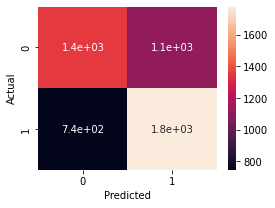

In [ ]:
cm = confusion_matrix(y_test,KNN_pred)
cm
# after creating the confusion matrix, for better understaning plot the cm.
import seaborn as sn
plt.figure(figsize = (4,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# save model for reuse KNN
model_knn.save()

In [ ]:
loaded_knn_model = model_knn.load('./knn.pkl',  mode="pickle")
KNN_predict = loaded_knn_model.predict(X_test_vec)
print(KNN_predict)
sum(KNN_predict==y_test)*1.0/len(y_test)
model_knn.evaluate(KNN_predict, y_test, target_names=[str(i) for i in np.unique(y_test)])

KNeighborsClassifier()
[0 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.55      0.65      0.59      2099
           1       0.70      0.61      0.66      2901

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.62      5000
weighted avg       0.64      0.63      0.63      5000



In [ ]:
# calling the ML calss For RANDOM FOREST
model_rf = MLModel("randomforest", "./RF.pkl")
model_rf.fit(X=X_train_vec, y=y_train)
RF_pred = model_rf.predict(X_test_vec)
print("accuracy: ", sum(RF_pred==y_test)*1.0/len(y_test))

print("Full classification evaluation report:")
model_rf.evaluate(RF_pred, y_test, target_names=[str(i) for i in np.unique(y_test)])

accuracy:  0.7032
Full classification evaluation report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2638
           1       0.67      0.72      0.70      2362

    accuracy                           0.70      5000
   macro avg       0.70      0.70      0.70      5000
weighted avg       0.71      0.70      0.70      5000



Text(15.0, 0.5, 'Actual')

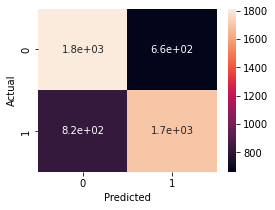

In [ ]:
cm = confusion_matrix(y_test,RF_pred)
cm
# after creating the confusion matrix, for better understaning plot the cm.
import seaborn as sn
plt.figure(figsize = (4,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# save model for reuse RANDOM FOREST
model_rf.save()

In [ ]:
loaded_rf_model = model_rf.load('./RF.pkl',  mode="pickle")
RF_predict = loaded_rf_model.predict(X_test_vec)
print(RF_predict)
sum(RF_predict==y_test)*1.0/len(y_test)
model_rf.evaluate(RF_predict, y_test, target_names=[str(i) for i in np.unique(y_test)])

RandomForestClassifier(n_estimators=10)
[0 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2638
           1       0.67      0.72      0.70      2362

    accuracy                           0.70      5000
   macro avg       0.70      0.70      0.70      5000
weighted avg       0.71      0.70      0.70      5000



In [ ]:
# calling the ML calss For SUPPORT VECTOR MACHINE
model_svm = MLModel("svm", "./SVM.pkl")
model_svm.fit(X=X_train_vec, y=y_train)
SVM_pred = model_svm.predict(X_test_vec)
print("accuracy: ", sum(SVM_pred==y_test)*1.0/len(y_test))

print("Full classification evaluation report:")
model_svm.evaluate(SVM_pred, y_test, target_names=[str(i) for i in np.unique(y_test)])

accuracy:  0.7328
Full classification evaluation report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      2286
           1       0.77      0.72      0.74      2714

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.74      0.73      0.73      5000



Text(15.0, 0.5, 'Actual')

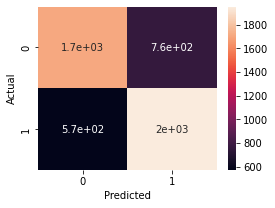

In [ ]:
cm = confusion_matrix(y_test,SVM_pred)
cm
# after creating the confusion matrix, for better understaning plot the cm.
import seaborn as sn
plt.figure(figsize = (4,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# save model for reuse SUPPORT VECTOR MACHINE
model_svm.save()

In [ ]:
loaded_svm_model = model_svm.load('./SVM.pkl',  mode="pickle")
SVM_predict = loaded_svm_model.predict(X_test_vec)
print(SVM_predict)
sum(SVM_predict==y_test)*1.0/len(y_test)
model_svm.evaluate(SVM_predict, y_test, target_names=[str(i) for i in np.unique(y_test)])

SVC()
[0 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      2286
           1       0.77      0.72      0.74      2714

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.74      0.73      0.73      5000



#***SUMMARY***
<table>
<tr>
<td>MODELS</td>

</tr>
<tr><td>    </td>
<td>Accuracy</td>
<td>f1_score</td>

</tr>
<tr><td>  LOGISTIC REGRESSION</td>
<td>0.7222</td>
<td>0.72</td>

<tr><td>  NAIVE BAYES </td>
<td>0.7156</td>
<td>0.72</td>

<tr><td>  K-NEAREST NEIGHBORS </td>
<td>0.6266</td>
<td>0.63</td>

</tr>
<tr><td>  RANDOM FOREST </td>
<td>0.7032</td>
<td>0.70</td>

</tr>
<tr><td>  SUPPORT VECTOR MACHINE </td>
<td>0.7328</td>
<td>0.73</td>

</tr>
</table>

#***III. TODO USE THE DIFFERENT FEATURE ENGINEERING TECHNIQUES - BoW, TD-IDF ADN Word Embeddings***


#1) BOW TECHNIQUE

In [ ]:
bow=CountVectorizer( min_df=2, max_features=100)
bow.fit(df['text'])
bow_df=bow.transform(df['text']).toarray()
print('feature name==',bow.get_feature_names()[:10])
print('number of uniqe words',bow_df.shape[1])
print('shape',bow_df.shape)
bow_train=pd.DataFrame(bow_df)
bow_train.head()

feature name== ['always', 'amp', 'another', 'back', 'bad', 'bed', 'best', 'better', 'cant', 'cold']
number of uniqe words 100
shape (20000, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#2) TF-IDF TECHNIQUE

In [ ]:
tfidf=TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_features=1000)
tfidf.fit(df['text'])
tfidf_df=tfidf.transform(df['text']).toarray()
print('number of uniqe words',bow_df.shape[1])
print('shape',tfidf_df.shape)
tfidf_train=pd.DataFrame(tfidf_df)
tfidf_train.head()

number of uniqe words 100
shape (20000, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.520851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#3) Word2vec TECHNIQUE

In [ ]:
tokenize=df['text'].apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, size = 100, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(df['text']),epochs=20)

(2717122, 2879900)

In [ ]:
w2vec_model.most_similar('bed')

[('shower', 0.6765481233596802),
 ('awake', 0.6282972097396851),
 ('den', 0.6087213158607483),
 ('calm', 0.5840011835098267),
 ('layin', 0.5795912742614746),
 ('sweepy', 0.5792236328125),
 ('lib', 0.5781327486038208),
 ('laying', 0.5736610293388367),
 ('waste', 0.5708576440811157),
 ('hay', 0.566982090473175)]

In [ ]:
w2v_words = list(w2vec_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  20827
sample words  ['love', 'health4uandpets', 'u', 'guys', 'r', 'best', 'im', 'meeting', 'one', 'besties', 'tonight', 'cant', 'wait', 'girl', 'talk', 'thanks', 'twitter', 'add', 'sunisa', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart', 'sick', 'really', 'cheap', 'hurts', 'much', 'eat', 'real', 'food', 'plus', 'friends', 'make', 'soup', 'effect', 'everyone', 'tell', 'burst', 'laughing', 'loud', 'making', 'come', 'sulk', 'thans', 'response', 'ihad']


In [ ]:
from model import sentiment